In [4]:
import sys
sys.path.append('/Users/nathanieldake/.virtualenvs/test-eda-pip-install-venv/lib/python3.7/site-packages')

# Dask delayed and persist experimentation

In [1]:
# Useful info here: https://www.youtube.com/watch?v=SHqFmynRxVU

import time
import random

# The functions below could be thought of as:
# inc: load data, dec: process data, add: combine data

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

# Running sequentially
start = time.time()
x = inc(1)
y = dec(2)
z = add(x, y)
end = time.time()
print(f'z: {z}, time elapsed: {round(end - start, 2)}')



z: 3, time elapsed: 1.85


In [7]:
# Can use dask to parallelize - inc and dec can be run at same time
# Specifically, we can use dask delayed as a decorator, making our functions lazy by default
from dask import delayed

@delayed
def inc(x):
    time.sleep(random.random())
    return x + 1

@delayed
def dec(x):
    time.sleep(random.random())
    return x - 1

@delayed
def add(x, y):
    time.sleep(random.random())
    return x + y

# Running code now will return instantly, giving us a dask delayed object (i.e. z)
start = time.time()
x = inc(1)
y = dec(2)
z = add(x, y)
end = time.time()
print(f'z: {z}, time elapsed: {round(end - start, 2)}')

z: Delayed('add-eb0e4523-b063-41ba-9ad8-7e54569d0e25'), time elapsed: 0.0


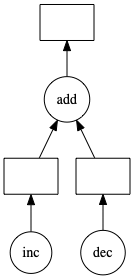

In [8]:
z.visualize()

In [9]:
start = time.time()
z.compute()
end = time.time()
print(f'z: {z}, time elapsed: {round(end - start, 2)}')

z: Delayed('add-eb0e4523-b063-41ba-9ad8-7e54569d0e25'), time elapsed: 1.32


# Experiment with dask delayed and persist

In [10]:
import dask
from dask import persist
from distributed import Client
client = Client()

# No call to `persist()`

In [27]:
%%time 
zs = []
for i in range(128):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

CPU times: user 15.1 ms, sys: 3.21 ms, total: 18.3 ms
Wall time: 15.8 ms


In [28]:
L = zs 
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])
        new_L.append(lazy)
    L = new_L
    

In [29]:
len(L)

1

In [30]:
%%time
L = dask.compute(L)

CPU times: user 3.07 s, sys: 318 ms, total: 3.39 s
Wall time: 26.3 s


In [31]:
len(L)

1

# Call to `persist()`

In [32]:
%%time 
zs = []
for i in range(128):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

zs = persist(zs)

L = zs 
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])
        new_L.append(lazy)
    L = new_L
    

CPU times: user 32.9 ms, sys: 4.29 ms, total: 37.2 ms
Wall time: 34.1 ms


In [33]:
len(L)

1

In [34]:
%%time
L  = dask.compute(L)

CPU times: user 2.13 s, sys: 221 ms, total: 2.35 s
Wall time: 15.9 s


In [35]:
len(L)

1